In [ ]:
import numpy as np
import struct
import matplotlib.pyplot as plt

In [ ]:
def parseFeitCSI(fileName):
    RATE_MCS_MOD_TYPE_POS = 8
    RATE_MCS_MOD_TYPE_MSK = (0x7 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_CCK_MSK = (0 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_LEGACY_OFDM_MSK = (1 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_HT_MSK = (2 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_VHT_MSK = (3 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_HE_MSK = (4 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_EHT_MSK = (5 << RATE_MCS_MOD_TYPE_POS)
    RATE_MCS_CHAN_WIDTH_POS = 11
    RATE_MCS_CHAN_WIDTH_MSK = (0x7 << RATE_MCS_CHAN_WIDTH_POS)
    RATE_MCS_CHAN_WIDTH_20_VAL = 0
    RATE_MCS_CHAN_WIDTH_20 = (RATE_MCS_CHAN_WIDTH_20_VAL << RATE_MCS_CHAN_WIDTH_POS)
    RATE_MCS_CHAN_WIDTH_40_VAL = 1
    RATE_MCS_CHAN_WIDTH_40 = (RATE_MCS_CHAN_WIDTH_40_VAL << RATE_MCS_CHAN_WIDTH_POS)
    RATE_MCS_CHAN_WIDTH_80_VAL = 2
    RATE_MCS_CHAN_WIDTH_80 = (RATE_MCS_CHAN_WIDTH_80_VAL << RATE_MCS_CHAN_WIDTH_POS)
    RATE_MCS_CHAN_WIDTH_160_VAL = 3
    RATE_MCS_CHAN_WIDTH_160 = (RATE_MCS_CHAN_WIDTH_160_VAL << RATE_MCS_CHAN_WIDTH_POS)
    RATE_MCS_CHAN_WIDTH_320_VAL = 4
    RATE_MCS_CHAN_WIDTH_320 = (RATE_MCS_CHAN_WIDTH_320_VAL << RATE_MCS_CHAN_WIDTH_POS)
    RATE_HT_MCS_CODE_MSK = 7
    RATE_MCS_ANT_A_POS = 14
    RATE_MCS_ANT_A_MSK = (1 << RATE_MCS_ANT_A_POS)
    RATE_MCS_ANT_B_POS = 15
    RATE_MCS_ANT_B_MSK = (1 << RATE_MCS_ANT_B_POS)
    RATE_MCS_LDPC_POS = 16
    RATE_MCS_LDPC_MSK = (1 << RATE_MCS_LDPC_POS)
    RATE_MCS_SS_POS = 16
    RATE_MCS_SS_MSK = (1 << RATE_MCS_SS_POS)
    RATE_MCS_BEAMF_POS = 16
    RATE_MCS_BEAMF_MSK = (1 << RATE_MCS_BEAMF_POS)

    with open(fileName, mode='rb') as file:
        def parseHeader(data):
            header = {}
            header["csi_size"] = struct.unpack("I", data[0:4])[0]
            header["ftm_clock"] = struct.unpack("I", data[8:12])[0]
            header["timestamp"] = struct.unpack("Q", data[12:20])[0]
            header["num_rx"] = data[46]
            header["num_tx"] = data[47]
            header["num_subcarriers"] = struct.unpack("I", data[52:56])[0]
            header["rssi1"] = struct.unpack("I", data[60:64])[0]
            header["rssi2"] = struct.unpack("I", data[64:68])[0]
            header["source_mac"] = struct.unpack("BBBBBB", data[68:74])
            header["source_mac_string"] = "%02x:%02x:%02x:%02x:%02x:%02x" % struct.unpack("BBBBBB", data[68:74])
            header["rate_flags"] = struct.unpack("I", data[92:96])[0]

            rate_format = header["rate_flags"] & RATE_MCS_MOD_TYPE_MSK
            if rate_format == RATE_MCS_CCK_MSK:
                rate_format = "CCK"
            elif rate_format == RATE_MCS_LEGACY_OFDM_MSK:
                rate_format = "LEGACY_OFDM"
            elif rate_format == RATE_MCS_VHT_MSK:
                rate_format = "VHT"
            elif rate_format == RATE_MCS_HT_MSK:
                rate_format = "HT"
            elif rate_format == RATE_MCS_HE_MSK:
                rate_format = "HE"
            elif rate_format == RATE_MCS_EHT_MSK:
                rate_format = "EHT"
            else:
                rate_format = "unknown"
            header["rate_format"] = rate_format

            channel_width = header["rate_flags"] & RATE_MCS_CHAN_WIDTH_MSK
            if channel_width == RATE_MCS_CHAN_WIDTH_20:
                channel_width = "20"
            elif channel_width == RATE_MCS_CHAN_WIDTH_40:
                channel_width = "40"
            elif channel_width == RATE_MCS_CHAN_WIDTH_80:
                channel_width = "80"
            elif channel_width == RATE_MCS_CHAN_WIDTH_160:
                channel_width = "160"
            elif channel_width == RATE_MCS_CHAN_WIDTH_320:
                channel_width = "320"
            else:
                channel_width = "unknown"
            header["channel_width"] = channel_width

            header["mcs"] = header["rate_flags"] & RATE_HT_MCS_CODE_MSK
            header["antenna_a"] = True if header["rate_flags"] & RATE_MCS_ANT_A_MSK else False
            header["antenna_b"] = True if header["rate_flags"] & RATE_MCS_ANT_B_MSK else False
            header["ldpc"] = True if header["rate_flags"] & RATE_MCS_LDPC_MSK else False
            header["ss"] = 2 if header["rate_flags"] & RATE_MCS_SS_MSK else 1
            header["beamforming"] = True if header["rate_flags"] & RATE_MCS_BEAMF_MSK else False

            return header

        def parseCsiData(data, header):
            csi_matrix = np.zeros((header["num_subcarriers"], header["num_rx"], header["num_tx"]), dtype=complex)
            pos = 0
            for j in range(header["num_rx"]):
                for k in range(header["num_tx"]):
                    for n in range(header["num_subcarriers"]):
                        real = struct.unpack("h", data[pos:pos + 2])[0]
                        imag = struct.unpack("h", data[pos + 2:pos + 4])[0]
                        pos += 4
                        csi_matrix[n, j, k] = complex(real, imag)
            return csi_matrix

        fileContent = file.read()
        step = 0
        output = []
        while (len(fileContent) > step):
            data = {}
            data["header"] = parseHeader(fileContent[step:(step+272)])
            step += 272
            data["csi_matrix"] = parseCsiData(fileContent[step:(step + data["header"]["csi_size"])], data["header"])
            step += data["header"]["csi_size"]
            output.append(data)
        return output

In [ ]:
def print_all_measurements(csi_data):
    """Print detailed information for all CSI measurements"""
    print(f"\n{'='*80}")
    print(f"DETAILED CSI MEASUREMENTS ({len(csi_data)} total)")
    print(f"{'='*80}")

    for i, measurement in enumerate(csi_data):
        header = measurement["header"]
        csi_matrix = measurement["csi_matrix"]

        print(f"\n--- Measurement {i+1} ---")
        print(f"  Timestamp: {header['timestamp']}")
        print(f"  FTM Clock: {header['ftm_clock']}")
        print(f"  Source MAC: {header['source_mac_string']}")
        print(f"  Rate format: {header['rate_format']}")
        print(f"  Channel width: {header['channel_width']} MHz")
        print(f"  MCS: {header['mcs']}")
        print(f"  Num RX antennas: {header['num_rx']}")
        print(f"  Num TX antennas: {header['num_tx']}")
        print(f"  Num subcarriers: {header['num_subcarriers']}")
        print(f"  RSSI1: {header['rssi1']} dBm")
        print(f"  RSSI2: {header['rssi2']} dBm")
        print(f"  Antenna A: {header['antenna_a']}")
        print(f"  Antenna B: {header['antenna_b']}")
        print(f"  LDPC: {header['ldpc']}")
        print(f"  Spatial Streams: {header['ss']}")
        print(f"  Beamforming: {header['beamforming']}")
        print(f"  CSI matrix shape: {csi_matrix.shape}")
        # print(f"  CSI data range - Real: [{np.real(csi_matrix).min():.2f}, {np.real(csi_matrix).max():.2f}]")
        # print(f"  CSI data range - Imag: [{np.imag(csi_matrix).min():.2f}, {np.imag(csi_matrix).max():.2f}]")
        # print(f"  CSI magnitude range: [{np.abs(csi_matrix).min():.2f}, {np.abs(csi_matrix).max():.2f}]")

In [ ]:
if __name__ == "__main__":
    filename = "../data/20250925_4230hickoryRdApt3a.dat"  # Use the specified file path
    print(f"Parsing CSI data from: {filename}")

    try:
        csi_data = parseFeitCSI(filename)
        print(f"Successfully parsed {len(csi_data)} CSI measurement(s)")
        # print(csi_data)

        # Print all measurements in detail
        print_all_measurements(csi_data)

    except Exception as e:
        print(f"Error parsing CSI data: {e}")
        import sys
        sys.exit(1)

Parsing CSI data from: /content/csi.dat
Successfully parsed 6 CSI measurement(s)

DETAILED CSI MEASUREMENTS (6 total)

--- Measurement 1 ---
  Timestamp: 0
  FTM Clock: 1697792932
  Source MAC: 98:cc:f3:e8:1f:93
  Rate format: HE
  Channel width: 80 MHz
  MCS: 2
  Num RX antennas: 2
  Num TX antennas: 1
  Num subcarriers: 996
  RSSI1: 81 dBm
  RSSI2: 85 dBm
  Antenna A: True
  Antenna B: True
  LDPC: True
  Spatial Streams: 2
  Beamforming: True
  CSI matrix shape: (996, 2, 1)

--- Measurement 2 ---
  Timestamp: 0
  FTM Clock: 3806032868
  Source MAC: 98:cc:f3:e8:1f:93
  Rate format: HE
  Channel width: 80 MHz
  MCS: 2
  Num RX antennas: 2
  Num TX antennas: 1
  Num subcarriers: 996
  RSSI1: 79 dBm
  RSSI2: 84 dBm
  Antenna A: True
  Antenna B: True
  LDPC: True
  Spatial Streams: 2
  Beamforming: True
  CSI matrix shape: (996, 2, 1)

--- Measurement 3 ---
  Timestamp: 0
  FTM Clock: 103427412
  Source MAC: 98:cc:f3:e8:1f:93
  Rate format: HE
  Channel width: 80 MHz
  MCS: 2
  Num RX a

In [22]:
for i, measurement in enumerate(csi_data):
    print(f"Processing measurement {i+1}...")

csi_matrix = measurement["csi_matrix"]
csi_magnitude = np.abs(csi_matrix)

Processing measurement 1...
Processing measurement 2...
Processing measurement 3...
Processing measurement 4...
Processing measurement 5...
Processing measurement 6...


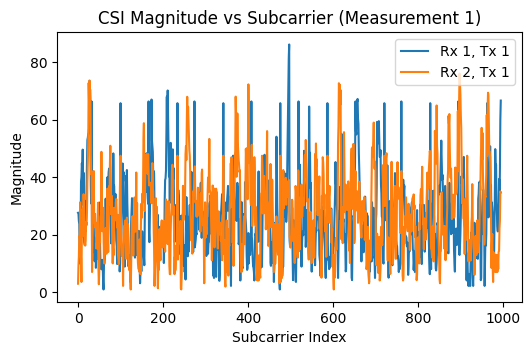

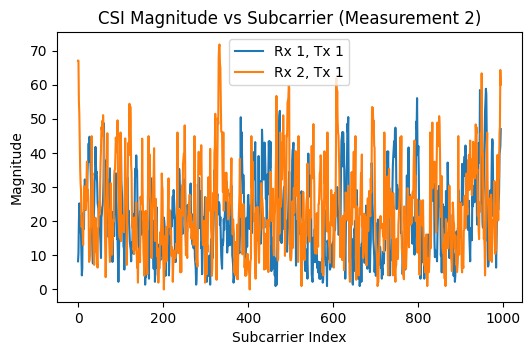

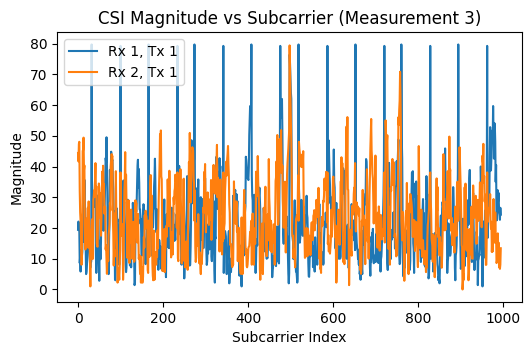

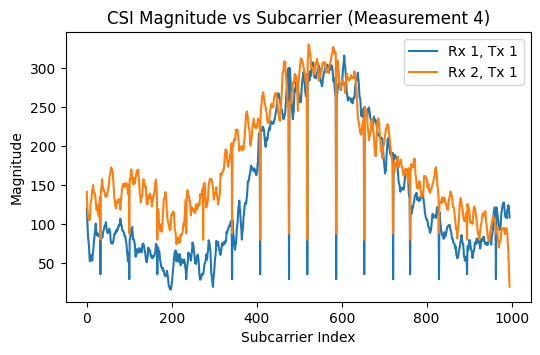

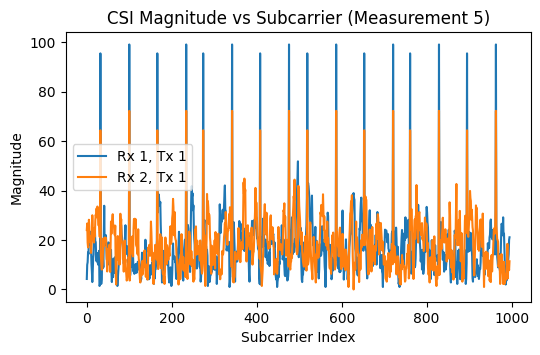

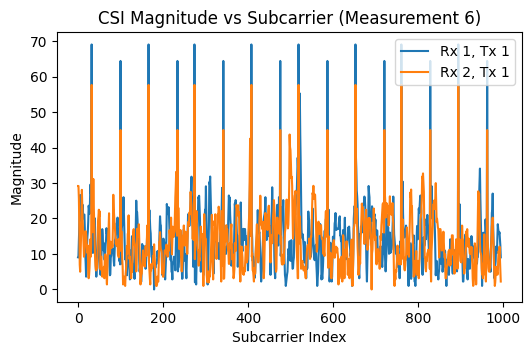

In [23]:
for i, measurement in enumerate(csi_data):
    csi_matrix = measurement["csi_matrix"]
    csi_magnitude = np.abs(csi_matrix)
    num_rx = measurement["header"]["num_rx"]
    num_tx = measurement["header"]["num_tx"]
    num_subcarriers = measurement["header"]["num_subcarriers"]

    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.set_title(f"CSI Magnitude vs Subcarrier (Measurement {i+1})")
    ax.set_xlabel("Subcarrier Index")
    ax.set_ylabel("Magnitude")

    for rx in range(num_rx):
        for tx in range(num_tx):
            ax.plot(range(num_subcarriers), csi_magnitude[:, rx, tx], label=f"Rx {rx+1}, Tx {tx+1}")

    ax.legend()
    plt.show()

In [ ]:
# import json

# # Custom encoder to handle complex numbers
# class ComplexEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, complex):
#             return [obj.real, obj.imag]
#         elif isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)

# output_filename = "csi_data.json"

# with open(output_filename, 'w') as f:
#     json.dump(csi_data, f, cls=ComplexEncoder, indent=4)

# print(f"CSI data saved to {output_filename}")